In [1]:
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, imshow
import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time

plt.rcParams.update({
    'font.size': 14, 
    'lines.linewidth':4, 
    "figure.figsize": (80, 16)
})

In [2]:
import sklearn
sklearn.__version__

'0.22.1'

In [3]:
pics = [
    'CG-IS-001 Box 09-10 (24.65 to 29.50)split.png',
    'CG-IS-005 Box 03-04 (5.40 to 11.30)split.png',
    'CH-IU-013 Box 01-02 (0.00 to 5.60)split.png'
]

## Examine the specs of the image

In [4]:
t0 = time.time()

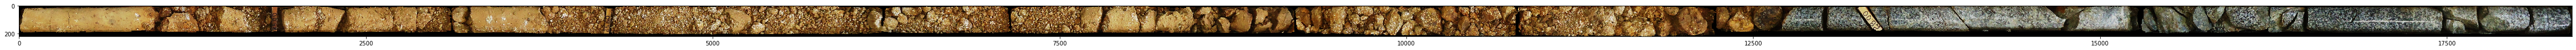

In [5]:
img1 = imread(os.path.join('imgs', pics[0]))
plt.figure(figsize = (80, 10))
plt.imshow(img1)
plt.show()

In [6]:
print(f'dims = {img1.shape}, max value = {img1.max()}, min value = {img1.min()}')

dims = (221, 18402, 3), max value = 1.0, min value = 0.0


### Make sure color sequence is R -> G -> B

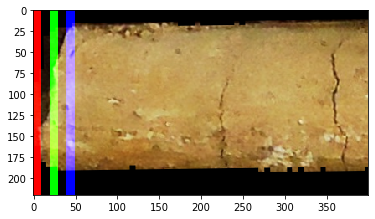

In [7]:
img1_head = img1[:, :400, :].copy()
img1_head[:, :10, 0] = 1.0
img1_head[:, 20:30, 1] = 1.0
img1_head[:, 40:50, 2] = 1.0
imshow(img1_head)

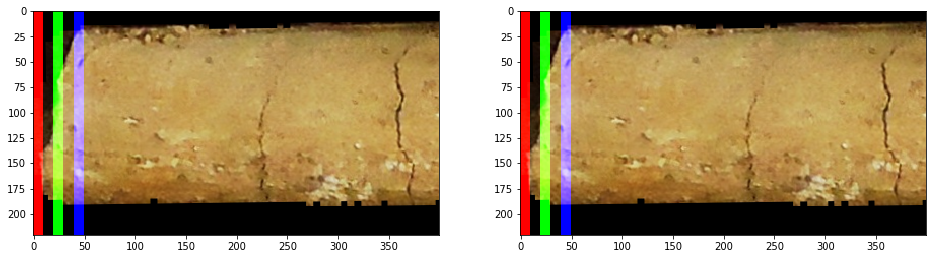

In [8]:
fig = plt.figure(1, figsize = (16, 8))
plt.subplot(121)
plt.imshow(img1_head)
plt.subplot(122)
plt.imshow(img1_head)
plt.show()

## Analyze color channels in the image
As the format of the images are examined, we can then compare the RGB ingredient in the images, which is similar to how human eyes compare different objects.

In [9]:
def colorIntensity(vals, title, ylabel):
    color_map = {0: 'r', 1: 'g', 2: 'b'}
    y_lim = (0, 1)
    fig = plt.figure(figsize = (80, 15))
    plt.ylim(y_lim)
    plt.ylabel(ylabel)
    plt.grid(True)
    for i in range(vals.shape[1]):
        plt.plot(vals[:, i], c = color_map[i])
    plt.title(title, fontsize = 40)
    plt.show()

The subplotting version of above feature:
```python
def colorIntensity(vals, title):
    color_map = {0: 'r', 1: 'g', 2: 'b'}
    y_lim = (0, 1)
    fig = plt.figure(figsize = (80, 10))
    fig.title(title)
    for i in range(vals.shape[1]):
        ax = fig.add_subplot(3, 1, i+1)
        ax.plot(vals[:, i], c = color_map[i])
        ax.set_ylim(y_lim)
        ax.grid(True)
    plt.show()
```

In [10]:
class ImageInfo():
    def __init__(self, ch_abs, ch_rel, valid_pxls):
        assert ch_abs.shape[0] == ch_rel.shape[0] == len(valid_pxls), \
            "Mismatched array dimensions"
        self.ch_abs = ch_abs
        self.ch_rel = ch_rel
        self.valid_pxls = valid_pxls
    def __repr__(self):
        return f"ImageInfo: ch_abs shape = {self.ch_abs.shape}, ch_rel shape = {self.ch_rel.shape}, {len(self.valid_pxls)}"

In [11]:
def showChannels(inp):
    h, w, c = inp.shape
    channel_absolute = np.empty((0, c), float)
    channel_relative = np.empty((0, c), float)
    ranges = list()
    outline = np.zeros((h, w))
    for i in range(w):
        col_slice = inp[:, i, :]
        all_color = col_slice.sum(axis = 1)
        min_step = 1 / 255
        valid_range = np.argwhere(all_color >= min_step).ravel()
#         valid_idx = np.argwhere(all_color >= min_step).ravel()
#         valid_range = range(valid_idx[0], valid_idx[-1] + 1)
        ranges.append(valid_range)
        outline[valid_range, i] = min_step * 100
        p = np.average(col_slice[valid_range], axis = 0)
        channel_absolute = np.vstack((channel_absolute, p))
        rel = p / np.sum(p)
        channel_relative = np.vstack((channel_relative, rel))
#     plt.figure(figsize = (80, 10))
#     plt.title('valid area', fontsize = 50)
#     imshow(outline, cmap = 'gray')
#     plt.show()
    fig = plt.figure(1, figsize = (16, 8))
    plt.subplot(121)
    plt.imshow(inp[:, :400, :])
    plt.title('original image')
    plt.subplot(122)
    plt.imshow(outline[:, :400], cmap = 'viridis')
    plt.title('valid area')
    plt.show()
    colorIntensity(channel_absolute, 'Individual Brightness', '')
    colorIntensity(channel_relative, 'Relative Brightness', '%')
    del inp, outline
    return ImageInfo(channel_absolute, channel_relative, ranges)

In [12]:
def analyzeImg(png_name):
    img = imread(os.path.join('imgs', png_name))
    plt.figure(figsize = (80, 10))
    plt.title(png_name, fontsize = 100)
    imshow(img)
    plt.show()
    return showChannels(img)

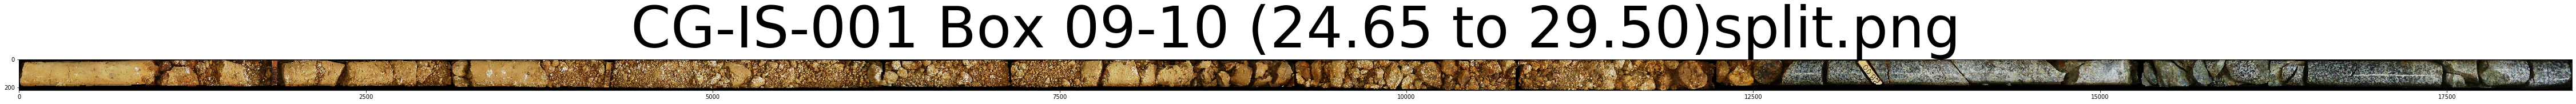

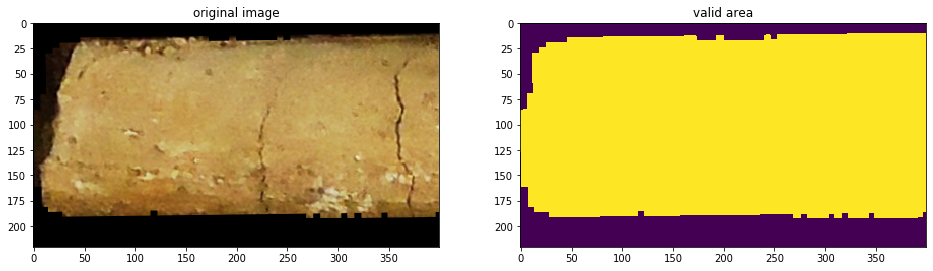

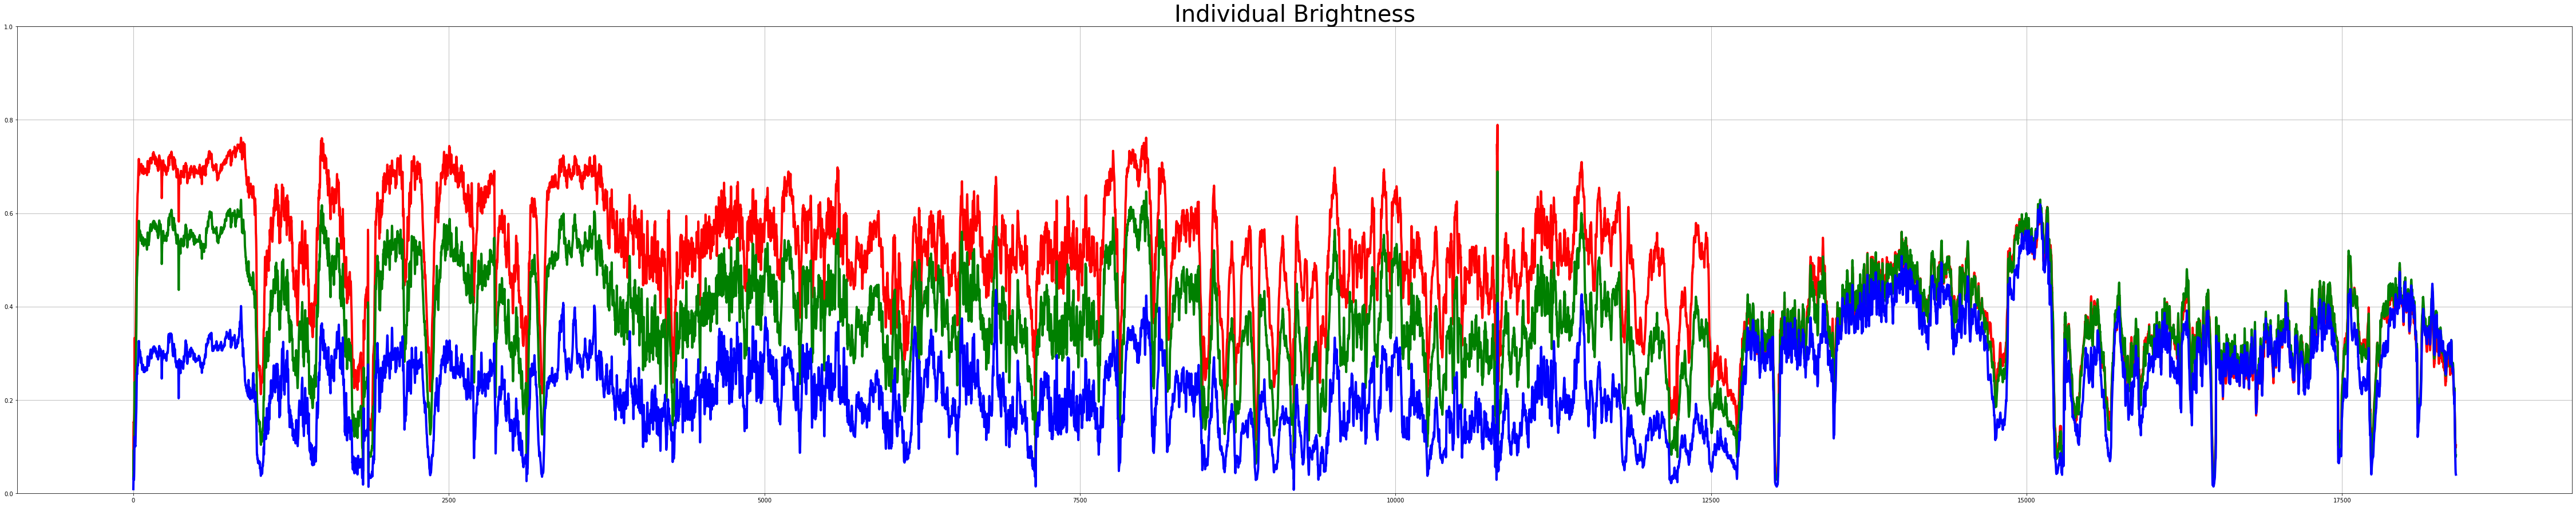

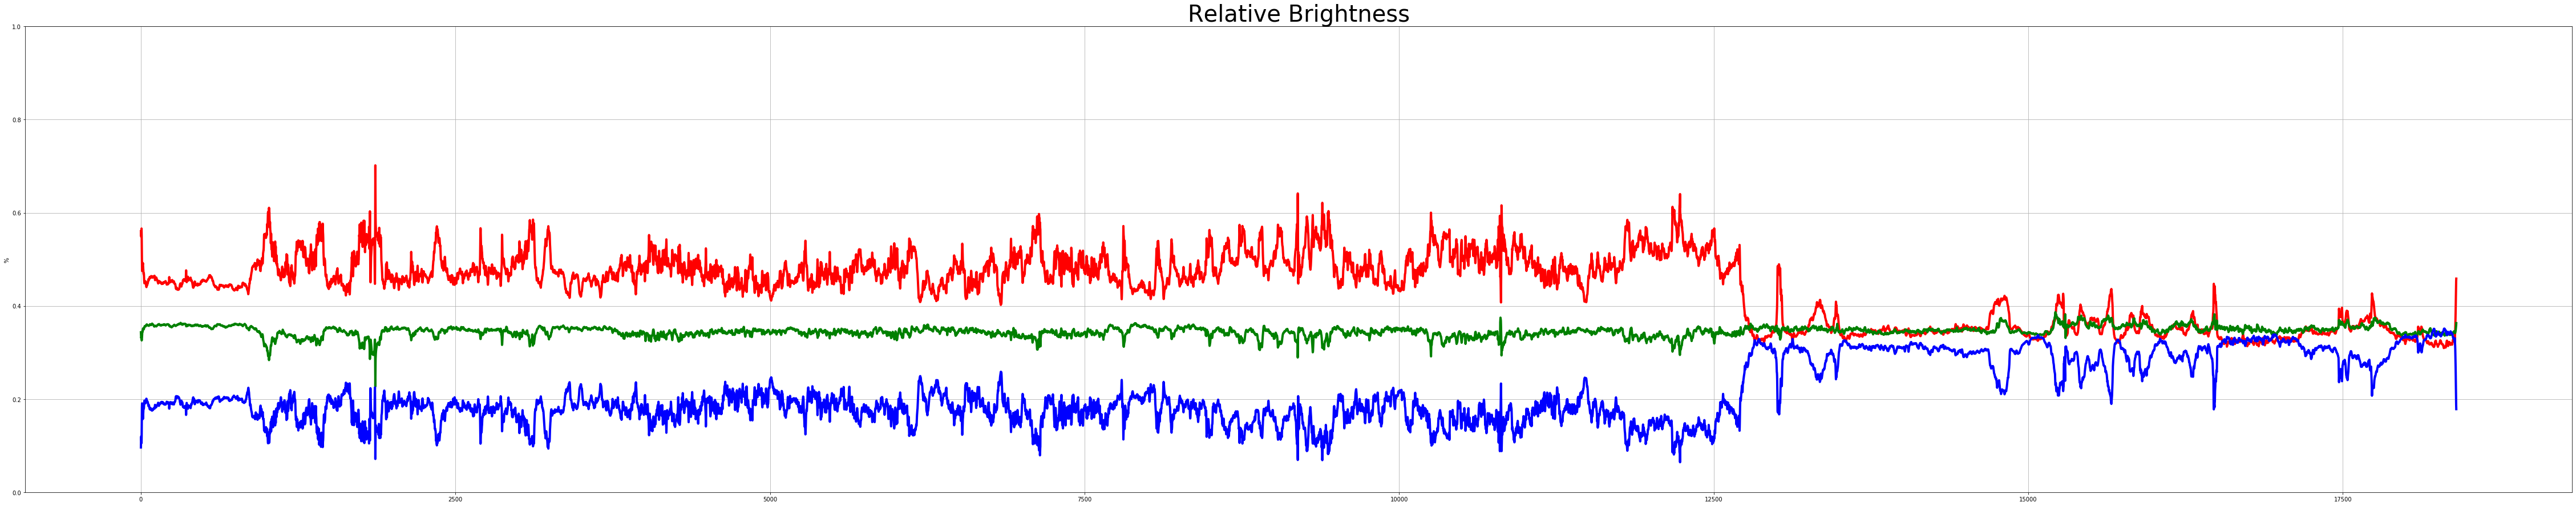

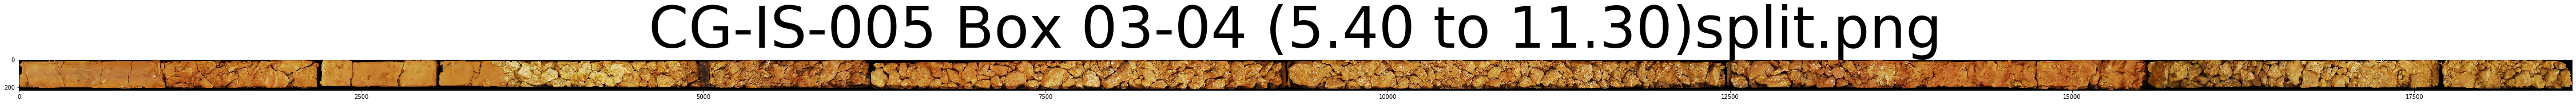

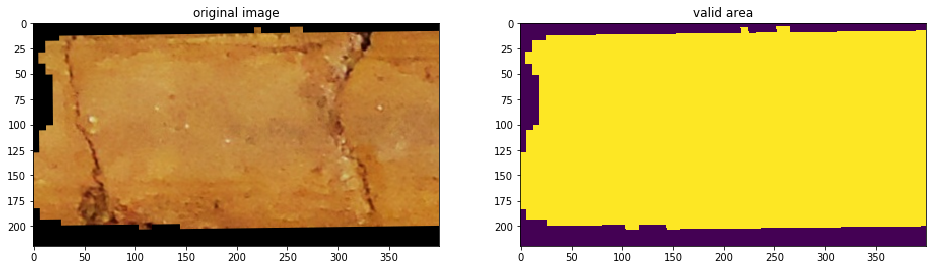

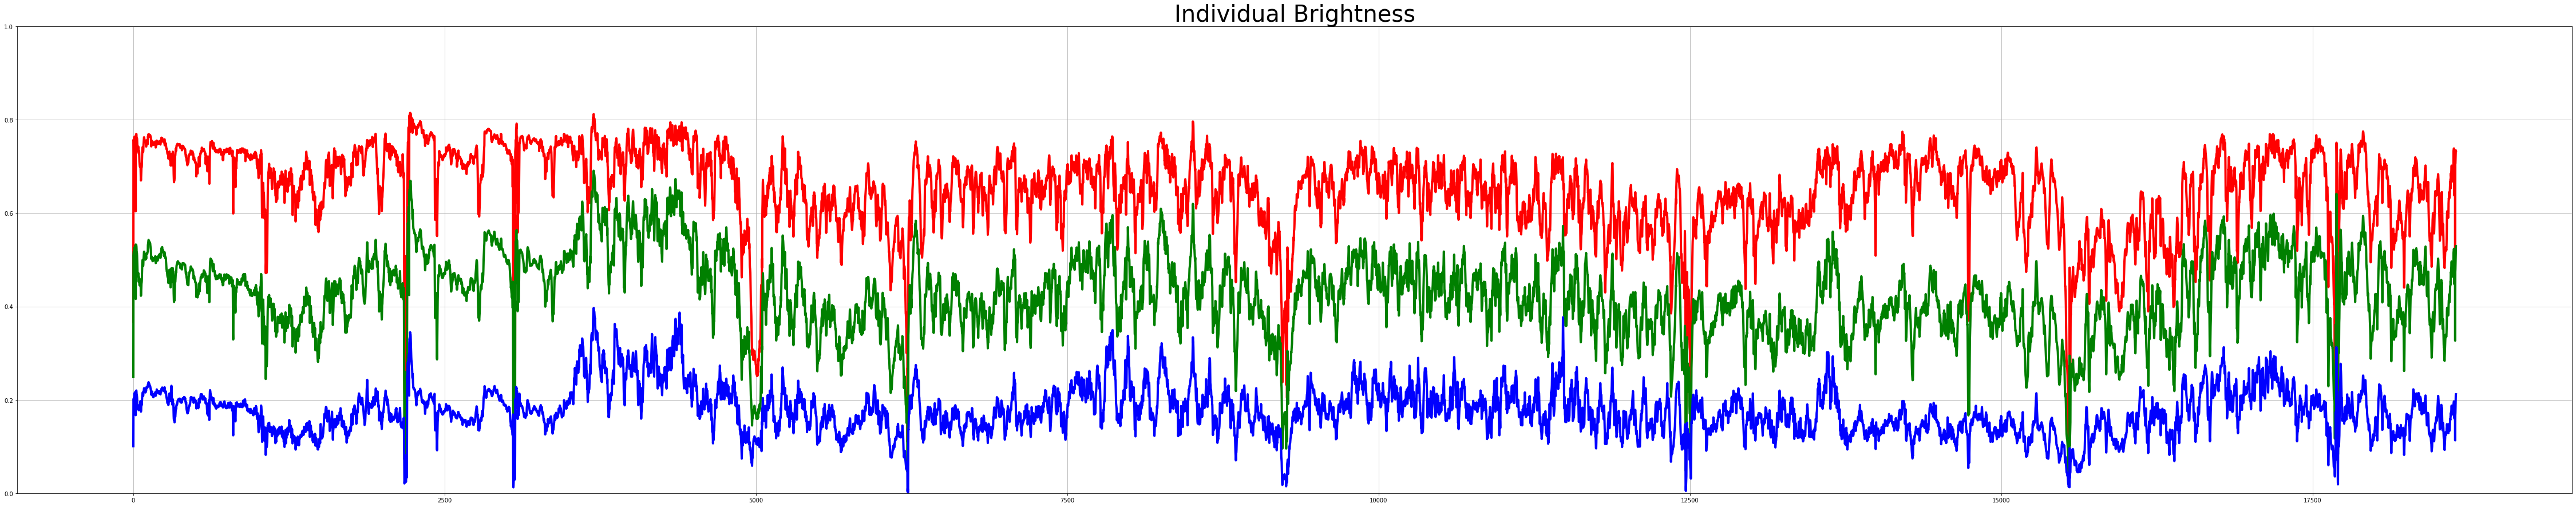

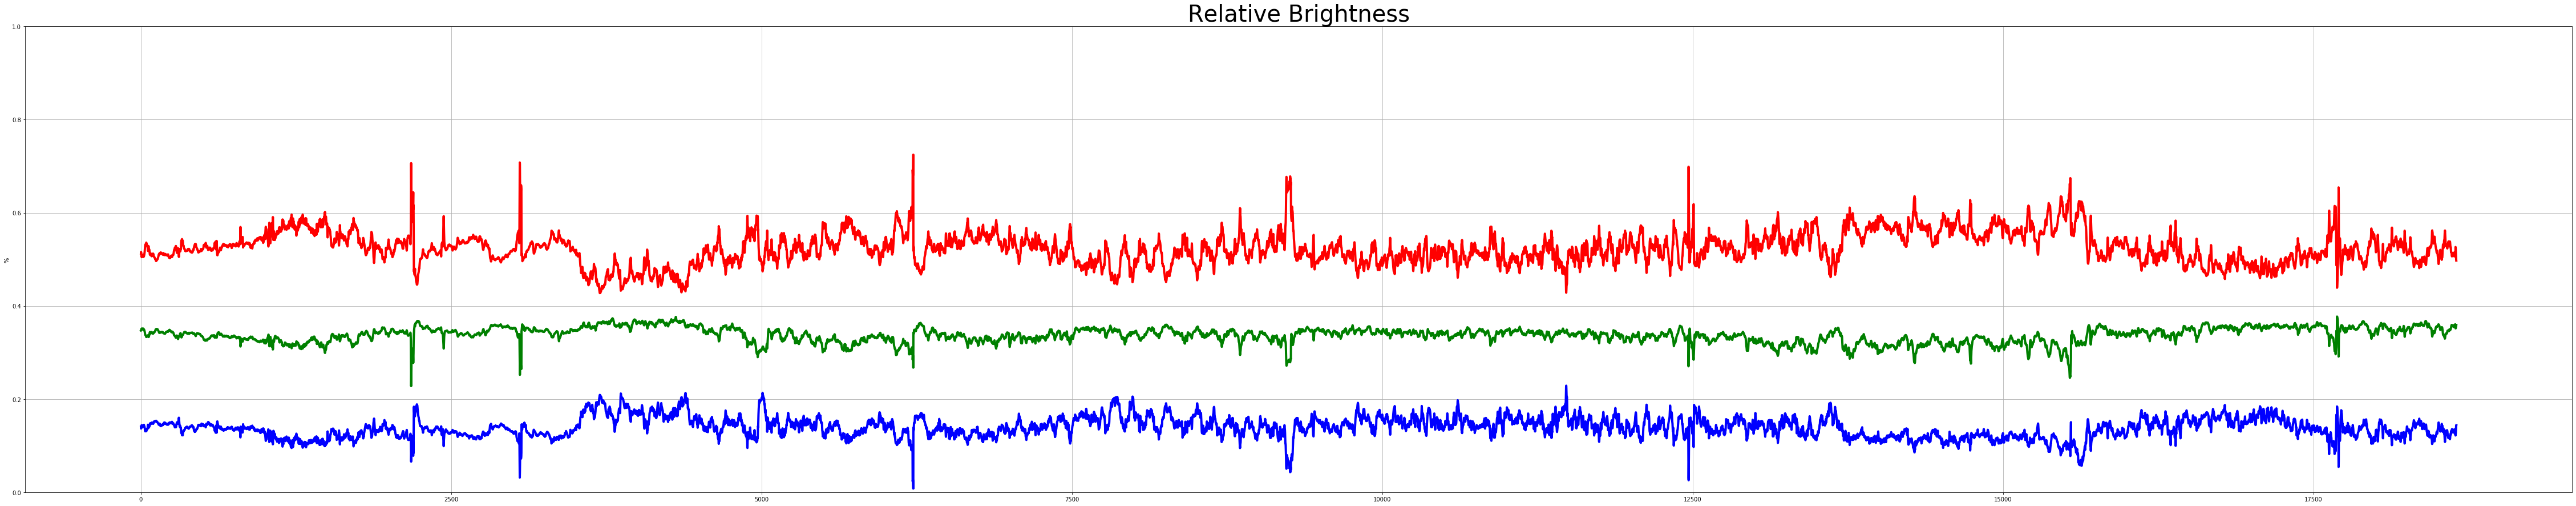

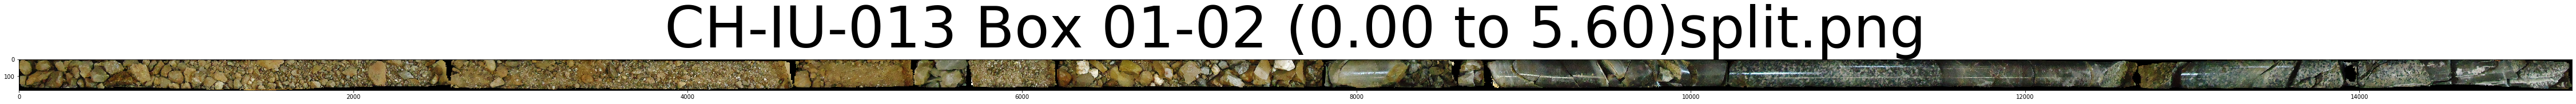

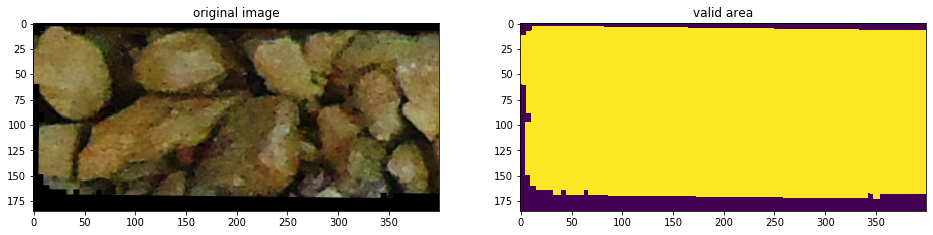

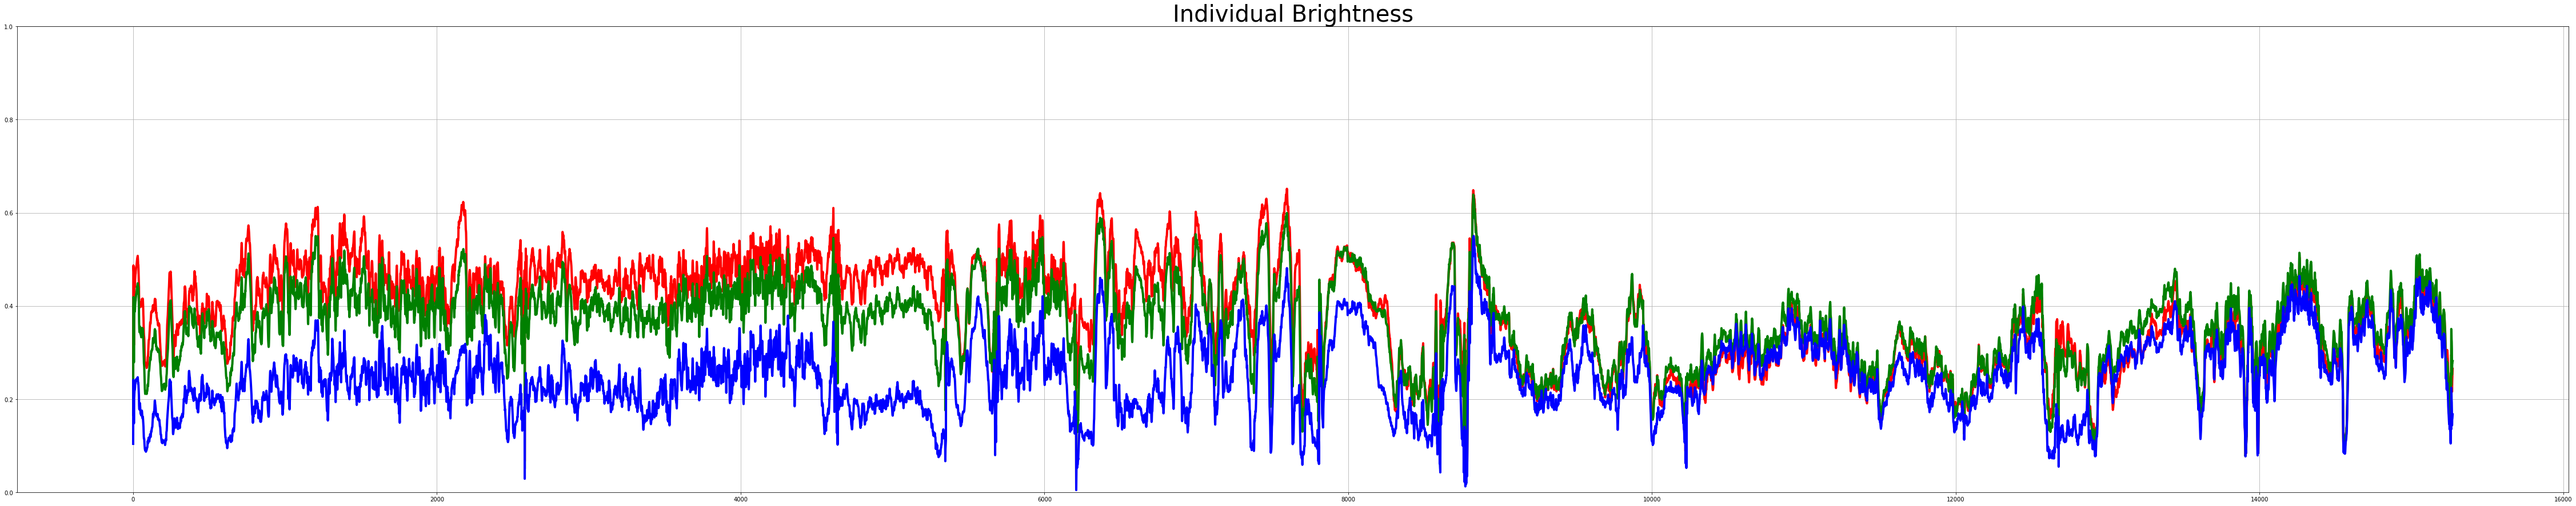

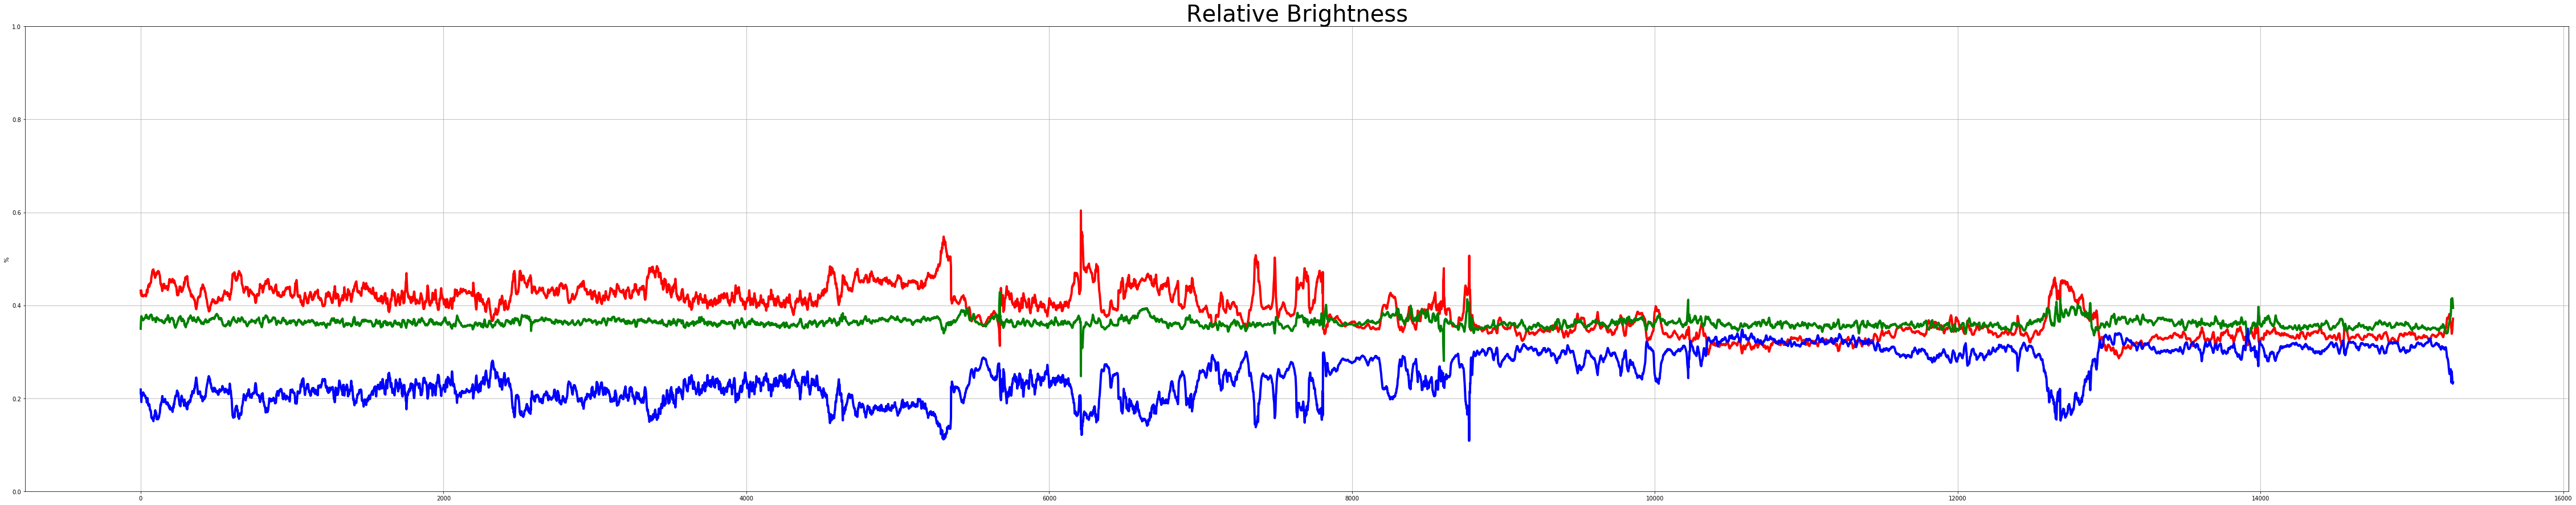

In [13]:
img_info = list()
for pic in pics:
    info = analyzeImg(pic)
    img_info.append(info)

In [14]:
print(f'It takes {time.time() - t0:.3f} seconds to get here')

It takes 14.690 seconds to get here


### Comment about RGB analysis
After looking into the RGB component of the core samples, here are some of my initial thoughts:
- sample_1 seems to consist of 2 distinct portions, and the junction divides the sample into 70% and 30% of the total length  
- rock type of sample_2 seems homogeneous, and it's very similar to the first 70% of sample_1
- sample_3 also consists of 2 distinct portions, and the juction divides the sample into 55% and 45% of the total length.  sample_3's tailing 45% seems having a composition very similar to sample_1's tailing 30%.

## Texture analysis
As the RGB component of the samples has been analyzed, we can know also include the texture into the formula.  To achieve this, my thought is to feed the images to a pre-trained CNN model without the top layer for feature extraction.  After that, we can use clustering algorithms to group similar sample portions together.

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

In [16]:
# Make sure GPU can be used by TensorFlow
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) > 0, \
    "Not enough GPU hardware devices available"
# config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Extract examples from core images
Because the original image is very wide, I will divide each image into several sections and extract one sub-image from each section.  For now, I will use 20 sections for every image.

According to https://keras.io/api/applications/resnet/#resnet50-function, the smallest input width/height for ResNet50 is 32.  Here I try to extract from the sample 4 times of this on each dimension, which is a 128x128 for each example.

In [17]:
def getSubs(img, n, area):
    H, W, C = img.shape
    init, end = int(W * 0.01), int(W * 0.99)
    grids = np.linspace(init, end, n+1).astype(int)
    secs = list()
    for i, idx in enumerate(grids[:-1]):
        offset = idx
        top, btm = 0, H - 1
        for j in range(idx, grids[i + 1]):
            vld = area[j]
            h0, h1 = vld[0], vld[-1]
            top = h0 if h0 > top else top
            btm = h1 if h1 < btm else btm
            height = h1 - h0 + 1
            if height != len(vld) or height < int(magic * 1.1):
                offset = j
                top, btm = 0, H - 1
            if j - offset == magic:
                break
        gap = (btm - top + 1 - magic) // 2
        top_adj, btm_adj = top + gap, top + gap + magic
        secs.append((top_adj, btm_adj, offset, j))
    return secs

In [18]:
%%capture
from PIL import Image
import imageio

magic = 128
num_sections = 20
if not os.path.exists('data'):
    os.mkdir('data')
for img_n, path in enumerate(pics):
    img = imread(os.path.join('imgs', path))
    valid_area = img_info[img_n].valid_pxls
    secs = getSubs(img, num_sections, valid_area)
    for i, (i0, i1, j0, j1) in enumerate(secs):
        mtx = img[i0:i1, j0:j1, :]
        assert mtx.shape[2] == 3, f'{img_n}, {i}, {mtx.shape}'
        imageio.imwrite(os.path.join('data', f'img{img_n+1}_{i+1:02}.png'), mtx)
#         r, g, b = cv2.split(mtx)
#         mtx = cv2.merge([b, g, r])
#         mtx = (mtx / mtx.max() * 255).astype(int)
#         cv2.imwrite(os.path.join('data', f'img{img_n+1}_{i+1:02}.png'), mtx)
#         plt.imsave(os.path.join('data', f'img{img_n+1}_{i+1:02}.png'), mtx)

(128, 128, 3) (128, 128, 3) (128, 128, 3)


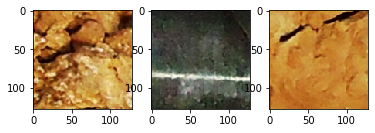

In [19]:
ii1 = imread(os.path.join('data', np.random.choice(os.listdir('data'))))
ii2 = imread(os.path.join('data', np.random.choice(os.listdir('data'))))
ii3 = imread(os.path.join('data', np.random.choice(os.listdir('data'))))
print(ii1.shape, ii2.shape, ii3.shape)
# ii1 = ii[:, :, :3]
# ii2 = ii[:, :, 3]
# print(ii1.shape, ii2.shape, ii2.sum())
plt.figure()
plt.subplot(131)
plt.imshow(ii1)
plt.subplot(132)
imshow(ii2)
plt.subplot(133)
imshow(ii3)
plt.show()

In [20]:
resnet50 = ResNet50(weights='imagenet', include_top = False)

In [21]:
features, names = list(), list()
for filename in os.listdir('data'):
    img = imread(os.path.join('data', filename))
#     img = imread(os.path.join('data', filename))[:, :, :3]
    img_prep = preprocess_input(np.expand_dims(img, axis = 0))
    feat = resnet50.predict(img_prep)
    features.append(feat.flatten())
    names.append(filename)

In [22]:
features = np.array(features)
print(features.shape)
clusters = list()
for k in range(2, 10):
    kmeans = KMeans(n_clusters = k, random_state = 2021).fit(features)
    clusters.append(kmeans.labels_)

(60, 32768)


In [23]:
for cl in clusters:
    print(silhouette_score(features, cl))

0.31997806
0.29358998
0.114710666
0.12550946
0.11162377
0.15570898
0.13313709
0.046999063


In [24]:
print(f'In total, it takes {time.time() - t0:.3f} seconds')

In total, it takes 31.289 seconds
